**базовые модели ML**

Евгений Борисов <esborisov@sevsu.ru>

решение задачи бинарной классификации

----

In [1]:
import numpy as np
import numpy.random as rng
# import pandas as pd
# from tqdm import tqdm
# from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [2]:
# tqdm.pandas ()
# pd.options.display.float_format = '{:,.2f}'.format

---

In [3]:
import sys 
import logging

logging.basicConfig(
    format=u'[%(levelname)-8s] %(asctime)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.DEBUG,
    stream=sys.stdout,
    )

# показывать выдачу всех строк ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## генерируем датасет

In [4]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X,target = make_blobs( n_samples=10_000, n_features=2, centers=2, cluster_std=[1.7,1.8] )
# X,target = make_blobs( n_samples=100_000, n_features=1024, centers=2, cluster_std=[1.7,1.8] )

# докидываем свободный член для линейных моделей
X = np.hstack([X,np.ones((X.shape[0],1))])

print( X.shape,target.shape )

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.33)
X_train, X_val, target_train, target_val = train_test_split(X_train, target_train, test_size=0.33)

del X,target

(100000, 3) (100000,)


In [5]:
logging.getLogger().setLevel(logging.CRITICAL) 
InteractiveShell.ast_node_interactivity = 'last_expr'

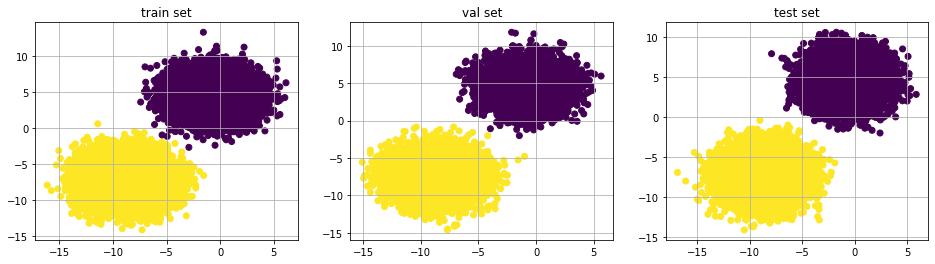

In [6]:
fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(16,4))
ax0.scatter(X_train[:,0],X_train[:,1],c=target_train)
ax0.grid()
ax0.set_title('train set')

ax1.scatter(X_val[:,0],X_val[:,1],c=target_val)
ax1.set_title('val set')
ax1.grid()

ax2.scatter(X_test[:,0],X_test[:,1],c=target_test)
ax2.set_title('test set')
ax2.grid()

In [7]:
logging.getLogger().setLevel(logging.DEBUG) 
InteractiveShell.ast_node_interactivity = 'all'

## SLP + MSQE + GD

In [8]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ np.eye(t.max()+1)[t] for t in [ target_train, target_val, target_test ] ]
# выход {-1,+1}
# y_train, y_val, y_test = [ (y*2)-1 for y in [ y_train, y_val, y_test ] ]

y_train.shape,y_val.shape,y_test.shape

((44890, 2), (22110, 2), (33000, 2))

In [9]:
y_train[:3,:]

array([[1., 0.],
       [0., 1.],
       [1., 0.]])

In [10]:
y_train.sum(axis=0), y_val.sum(axis=0), y_test.sum(axis=0),

(array([22425., 22465.]), array([11071., 11039.]), array([16504., 16496.]))

In [11]:
from lib.model.linear import SLP
# from lib.initiator.linear import NormalInitiatorLinearModel
from lib.initiator.linear import UniformInitiatorLinearModel

%xdel model

model = SLP(
    initiator=UniformInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=y_train.shape[1],
        high=.001,
    )
)

model.weight.shape

NameError: name 'model' is not defined


(3, 2)

In [12]:
from lib.loss.msqe import MSQE
loss_train = MSQE(model)
loss_val = MSQE(model)

---

In [13]:
from lib.optimizer.gd import GD 
from lib.optimizer.lrate import ConstLRA 

lra = ConstLRA(.1)

model = GD( 
    loss=loss_train, 
    loss_val=loss_val, 
    lra=lra,
).fit( 
    data_train=[X_train,y_train], 
    data_val=[X_val,y_val], 
    n_epoch=20,
)

100%|██████████| 20/20 [00:00<00:00, 122.05it/s, loss=0.497, lr=0.1]


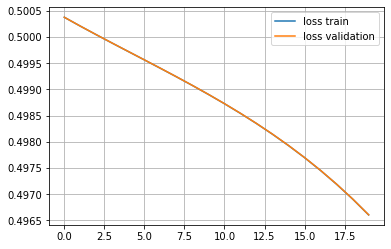

In [14]:
from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

predict is argmax output score vector
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     16504
           1       0.95      1.00      0.97     16496

    accuracy                           0.97     33000
   macro avg       0.97      0.97      0.97     33000
weighted avg       0.97      0.97      0.97     33000



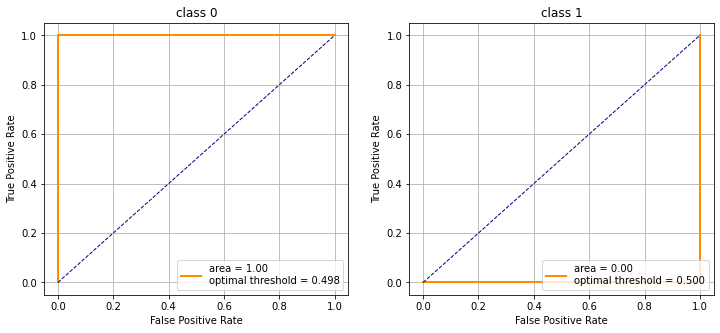

In [15]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,target_test)

In [16]:
# model.score(X_test)

## Softmax  + CCE + GD

In [17]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ np.eye(t.max()+1)[t] for t in [ target_train, target_val, target_test ] ]
# выход {0,+1}

y_train.shape,y_val.shape,y_test.shape

((44890, 2), (22110, 2), (33000, 2))

In [18]:
y_train[:3,:]

array([[1., 0.],
       [0., 1.],
       [1., 0.]])

In [19]:
y_train.sum(axis=0), y_val.sum(axis=0), y_test.sum(axis=0),

(array([22425., 22465.]), array([11071., 11039.]), array([16504., 16496.]))

In [20]:
from lib.model.linear import Softmax 
from lib.initiator.linear import NormalInitiatorLinearModel
# from lib.initiator.linear import UniformInitiatorLinearModel

model = Softmax(
    # initiator=UniformInitiatorLinearModel(
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=y_train.shape[1],
        scale=.1,
    )
)

model.weight.shape

(3, 2)

In [21]:
from lib.loss.crossentropy import CCE # ф-ция потери - категориальная кросс-энтропия
loss_train = CCE(model)
loss_val = CCE(model)

In [22]:
from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная

model = GD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.01),
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=100,
)

100%|██████████| 100/100 [00:01<00:00, 65.83it/s, loss=0.14, lr=0.01]


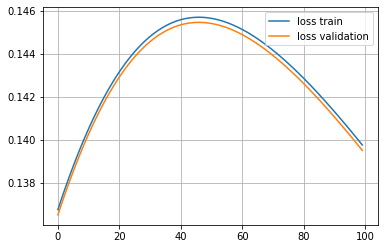

In [23]:
from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

predict is argmax output score vector
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16504
           1       1.00      1.00      1.00     16496

    accuracy                           1.00     33000
   macro avg       1.00      1.00      1.00     33000
weighted avg       1.00      1.00      1.00     33000



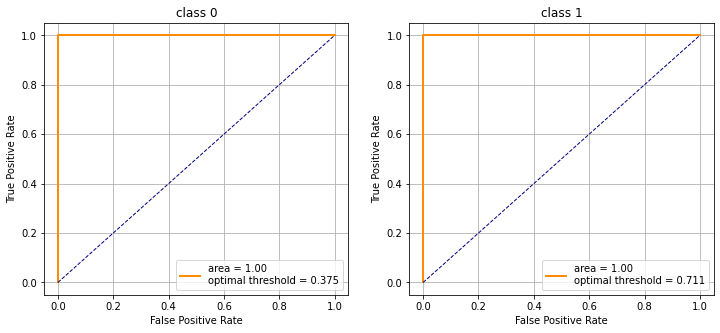

In [24]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,target_test)

In [25]:
# # (model.predict(X_test) == target_test).sum()/len(target_test)
# (model.predict(X_test) != target_test).sum()/len(target_test)
model.score(X_test)

array([[0.91181409, 0.08818591],
       [0.81506189, 0.18493811],
       [0.03612391, 0.96387609],
       ...,
       [0.83615389, 0.16384611],
       [0.04200615, 0.95799385],
       [0.0176315 , 0.9823685 ]])

## LogisticRegression + CCE + GD

In [26]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ t[:,np.newaxis] for t in [ target_train, target_val, target_test ] ]
# выход = метка класса

y_train.shape,y_val.shape,y_test.shape

((44890, 1), (22110, 1), (33000, 1))

In [27]:
y_train[:3,:]

array([[0],
       [1],
       [0]])

In [28]:
from lib.model.linear import SLP
from lib.initiator.linear import NormalInitiatorLinearModel

model = SLP( # логистическая регрессия 1./(1.+np.exp(-x.dot(w)) )
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=1,
    )
)

model.weight.shape

(3, 1)

In [29]:
from lib.loss.crossentropy import CCE # ф-ция потери - кросс-энтропия
loss_train = CCE(model)
loss_val = CCE(model)

In [30]:
from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная

model = GD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.1),
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=25,
)

100%|██████████| 25/25 [00:00<00:00, 191.75it/s, loss=0.0498, lr=0.1]


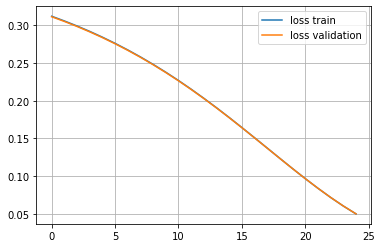

In [31]:
from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

In [32]:
# target_train

In [33]:
from lib.estimator.classifier import BinnaryClassifierScoreThreshold
model = BinnaryClassifierScoreThreshold(model).fit(X_train,target_train[:,np.newaxis])
# model.score_threshold

score threshold to predict is 0.7228376413656203
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16504
           1       1.00      1.00      1.00     16496

    accuracy                           1.00     33000
   macro avg       1.00      1.00      1.00     33000
weighted avg       1.00      1.00      1.00     33000



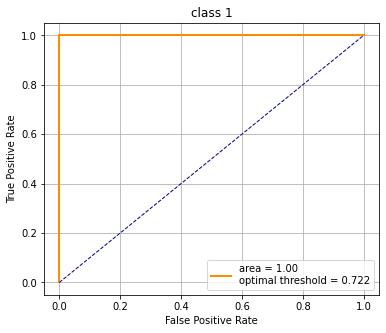

In [34]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,target_test,figsize=(6,5))